In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

In [2]:
#load datasets
data_csv = pd.read_csv("data (2).csv")
dataframe = pd.read_csv("heart rate variability and pulse rate variability.csv")
df = pd.read_csv('heart_attack_prediction_dataset.csv')

#display the first 5 rows of the datasets
print(data_csv.head())
print(dataframe.head())
print(df.head())

   Patient ID  ...  Adrenal_and_thyroid_disorders
0           1  ...                              1
1           2  ...                              0
2           3  ...                              0
3           4  ...                              0
4           5  ...                              0

[5 rows x 15 columns]
   Patient ID  Age  Gender  ...    HF_P  LF_HF_Ratio_P  Total power_P
0        2356   20       1  ...   408.1           1.05         1548.0
1        2357   20       2  ...   919.1           0.12         1184.0
2        2358   21       2  ...  5538.0           0.43         9817.0
3        2359   24       1  ...   528.0           0.54          965.4
4        2360   23       1  ...  1785.0           0.26         2656.0

[5 rows x 26 columns]
  Patient ID  Age  ...           Hemisphere  Heart Attack Risk
0    BMW7812   67  ...  Southern Hemisphere                  0
1    CZE1114   21  ...  Northern Hemisphere                  0
2    BNI9906   21  ...  Northern Hemisphere  

# STATISTICAL PROPERTIES

In [3]:
print(dataframe.describe())
print(dataframe.corr())

        Patient ID        Age  ...  LF_HF_Ratio_P  Total power_P
count    35.000000  35.000000  ...      35.000000      35.000000
mean   2373.000000  23.142857  ...       0.794286    4240.891429
std      10.246951   5.270020  ...       0.612566    2886.345970
min    2356.000000  19.000000  ...       0.120000     591.600000
25%    2364.500000  20.500000  ...       0.395000    1845.000000
50%    2373.000000  21.000000  ...       0.540000    3865.000000
75%    2381.500000  23.000000  ...       1.130000    6761.500000
max    2390.000000  39.000000  ...       2.410000    9817.000000

[8 rows x 26 columns]
                 Patient ID       Age  ...  LF_HF_Ratio_P  Total power_P
Patient ID     1.000000e+00  0.310993  ...       0.113159       0.013824
Age            3.109928e-01  1.000000  ...       0.008004      -0.388029
Gender         5.077378e-17 -0.220718  ...      -0.114343       0.168792
Height         9.249289e-02  0.259762  ...       0.114477      -0.171700
Weight         5.009546e-02

In [4]:
print(data_csv.describe())
print(data_csv.corr())

        Patient ID  ...  Adrenal_and_thyroid_disorders
count  2000.000000  ...                    2000.000000
mean   1000.500000  ...                       0.443500
std     577.494589  ...                       0.496922
min       1.000000  ...                       0.000000
25%     500.750000  ...                       0.000000
50%    1000.500000  ...                       0.000000
75%    1500.250000  ...                       1.000000
max    2000.000000  ...                       1.000000

[8 rows x 15 columns]
                               Patient ID  ...  Adrenal_and_thyroid_disorders
Patient ID                       1.000000  ...                       0.004823
Blood_Pressure_Abnormality       0.021430  ...                       0.318598
Level_of_Hemoglobin             -0.001083  ...                       0.030384
Genetic_Pedigree_Coefficient    -0.005239  ...                       0.008336
Age                             -0.030827  ...                      -0.025738
BMI           

# FEATURE ENGINEERING

In [5]:
#ensuring the common key name is named in all datasets
data_csv.rename(columns={'Patient ID': 'patient_id'}, inplace=True)
dataframe.rename(columns={'Patient ID': 'patient_id'}, inplace=True)
df.rename(columns={'Patient ID': 'patient_id'}, inplace=True)

#convert 'patient_id to smae data type
data_csv['patient_id'] = data_csv['patient_id'].astype(str)
dataframe['patient_id'] = data_csv['patient_id'].astype(str)
df['patient_id'] = data_csv['patient_id'].astype(str)

#Concatenate datasets column-wise
merged2 = pd.merge(df, dataframe, on='patient_id', how='inner')
merged2 = pd.merge(merged2, data_csv, on='patient_id', how='inner')

#initiallise label encoder
label_encoder = LabelEncoder()

#encode the categorical
if 'Patient ID' in merged2.columns:
    merged2['Patient ID'] = label_encoder.fit_transform(df['Patient ID'])
    
if 'Gender' in merged2.columns:
    merged2['Gender'] = label_encoder.fit_transform(merged2['Gender'])


# Split 'Blood Pressure' into 'Systolic' and 'Diastolic' if exist
if 'Blood pressure' in merged2.columns:
    merged2[['Systolic', 'Diastolic']] = merged2['Blood pressure'].str.split('/', expand=True).astype(float)
    merged2.drop(columns=['Blood pressure'], axis=1, inplace=True)
    
#define the target variable
target = 'Heart Attack Risk'
features = ['Age', 'Gender', 'Genetic_Pedigree_Coefficient', 'Visceral fat', 'Diabetes', 'BMI']

#Ensure all features exist in the dataframe
existing_features = [feature for feature in features if feature in merged2.columns]
missing_features = [feature for feature in features if feature not in merged2.columns]

print(f"Existing features: {existing_features}")
print(f"Missing features: {missing_features}")

#handle missing values
merged2 = merged2.dropna(subset=features + [target])
x = merged2[features].fillna("Na")
y = merged2[target]

print(df.describe())
df = df.select_dtypes(include=[np.number])
print('\nCorrelation matrix:')
print(df.corr())

Existing features: ['Age', 'Gender', 'Genetic_Pedigree_Coefficient', 'Visceral fat', 'Diabetes', 'BMI']
Missing features: []
               Age  Cholesterol  ...  Sleep Hours Per Day  Heart Attack Risk
count  8763.000000  8763.000000  ...          8763.000000        8763.000000
mean     53.707977   259.877211  ...             7.023508           0.358211
std      21.249509    80.863276  ...             1.988473           0.479502
min      18.000000   120.000000  ...             4.000000           0.000000
25%      35.000000   192.000000  ...             5.000000           0.000000
50%      54.000000   259.000000  ...             7.000000           0.000000
75%      72.000000   330.000000  ...             9.000000           1.000000
max      90.000000   400.000000  ...            10.000000           1.000000

[8 rows x 19 columns]

Correlation matrix:
                                      Age  ...  Heart Attack Risk
Age                              1.000000  ...           0.006403
Choles

In [6]:
print("columns in merged2: ")
print(merged2.columns)

columns in merged2: 
Index(['patient_id', 'Age_x', 'Sex_x', 'Cholesterol', 'Blood Pressure',
       'Heart Rate', 'Diabetes', 'Family History', 'Smoking_x', 'Obesity',
       'Alcohol Consumption', 'Exercise Hours Per Week', 'Diet',
       'Previous Heart Problems', 'Medication Use', 'Stress Level',
       'Sedentary Hours Per Day', 'Income', 'BMI_x', 'Triglycerides',
       'Physical Activity Days Per Week', 'Sleep Hours Per Day', 'Country',
       'Continent', 'Hemisphere', 'Heart Attack Risk', 'Age_y', 'Gender',
       'Height', 'Weight', 'BMI_y', 'BF%', 'Visceral fat', 'RHR', 'Test_time',
       'Hrmax', 'Vo2peak', 'SDNN_H', 'RMSSD_H', 'Pnn50_H', 'LF_H', 'HF_H',
       'LF_HF_Ratio_H', 'Total power_H', 'SDNN_P', 'RMSSD_p', 'Pnn50_P',
       'LF_P', 'HF_P', 'LF_HF_Ratio_P', 'Total power_P',
       'Blood_Pressure_Abnormality', 'Level_of_Hemoglobin',
       'Genetic_Pedigree_Coefficient', 'Age', 'BMI', 'Sex_y', 'Pregnancy',
       'Smoking_y', 'Physical_activity', 'salt_content_in_th

# SPLITTING DATASET

In [7]:
#split dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

#create and train the model
model = RandomForestClassifier(random_state=0)
cv_scores = cross_val_score(model, X_train, y_train, cv=5)
print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean CV Score: {cv_scores.mean()}")

#hyperparameter tuning using GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Best parameters from GridSearchCV
print(f'Best Parameters: {grid_search.best_params_}')

# Train the model with the best parameters
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)

Cross-Validation Scores: [0.5 0.5 0.6 0.4 0.4]
Mean CV Score: 0.48
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}


RandomForestClassifier(min_samples_leaf=4, min_samples_split=10,
                       n_estimators=200, random_state=0)

Accuracy: 1.0
Confusion Matrix:
[[6 0]
 [0 1]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         1

    accuracy                           1.00         7
   macro avg       1.00      1.00      1.00         7
weighted avg       1.00      1.00      1.00         7



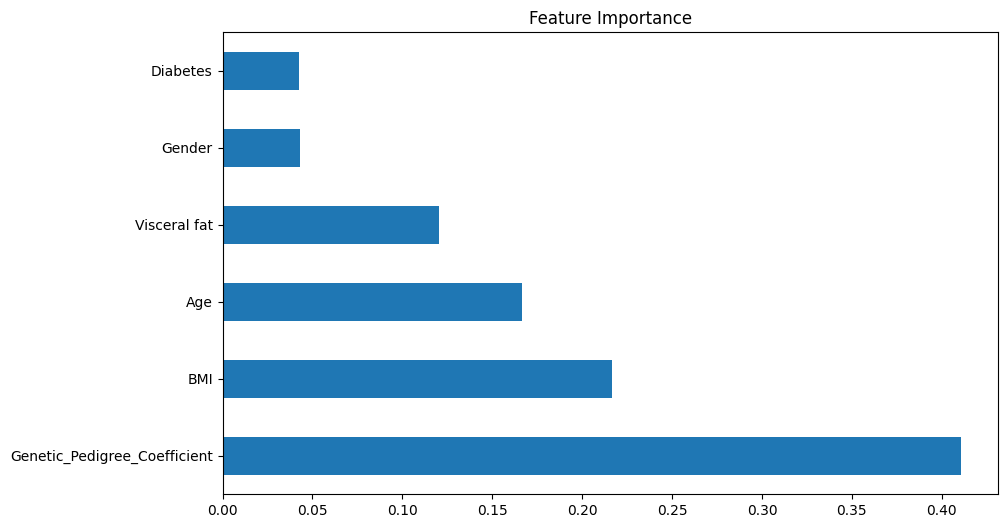

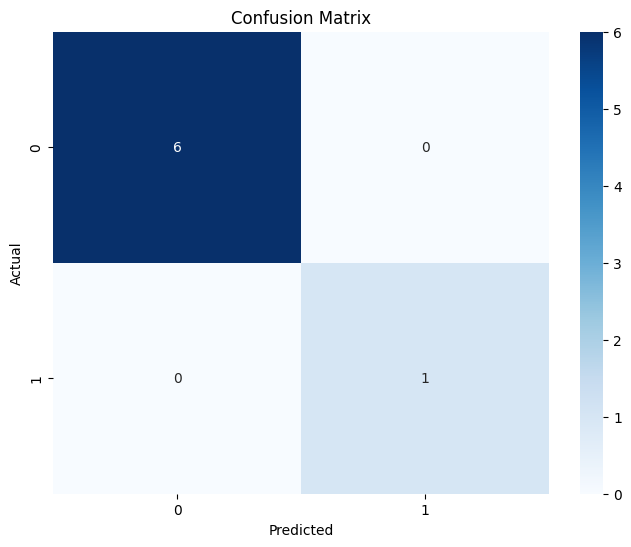

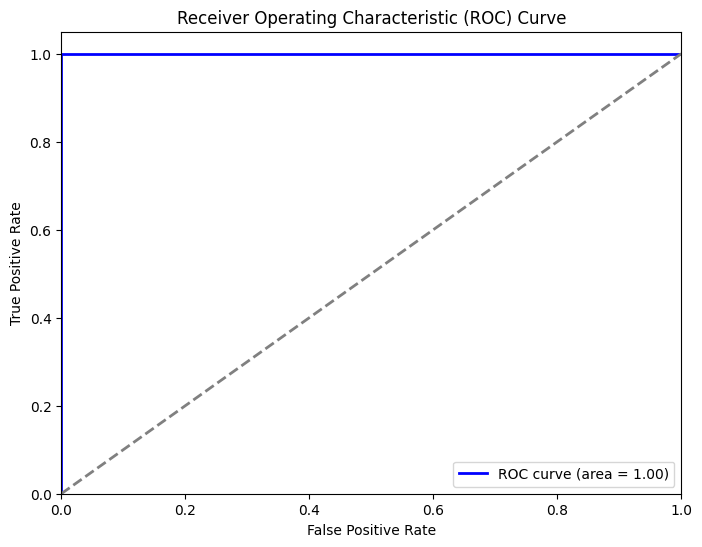

In [8]:
# Make predictions
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print('Confusion Matrix:')
print(conf_matrix)
print('Classification Report:')
print(class_report)

# Plot Feature Importance
plt.figure(figsize=(10, 6))
feature_importances = pd.Series(best_model.feature_importances_, index=existing_features)
feature_importances.nlargest(10).plot(kind='barh')
plt.title('Feature Importance')
plt.show()

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()